In [1]:
cd ../ms_lesion_seg/

/home/sam/projects/ms_lesion_seg/ms_lesion_seg


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import numpy as np
import nibabel as nib
import os
import sys
from utils.plot import *
from utils.train_loader import TrainLoader
from torch.utils.data import DataLoader
from models.cnn import CNN
import torch
from tqdm import tqdm
import gc
torch.backends.cudnn.benchmark = True

In [4]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['font.size'] = 22
plt.rcParams['image.cmap'] = 'Greys_r'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['image.interpolation'] = 'nearest'

In [5]:
data_dir = Path("/iacl/pg20/sam/data/ms_lesions_2021/validation")

In [6]:
patch_size = (64, 64, 1)
batch_size = 64
n_steps = 100000
lr = 1e-4
gpu_id = 0
device = torch.device(f'cuda:{gpu_id}')

In [7]:
ds = TrainLoader(
    data_dir=data_dir,
    patch_size=patch_size,
    drop_idx=0,
    n_steps=n_steps,
)

data_loader = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=False, # random patches are drawn
    pin_memory=True,
    num_workers=8,
) 

==================== Loading images into RAM ====================


100%|███████████████████████████████████████████████████████████████████| 8/8 [00:22<00:00,  2.83s/it]


In [8]:
model = CNN(
    n_img_channels=4,
    n_lbl_classes=1,
    kernel_size=3,
    n_layers=8,
    filters=256,
).to(device)

In [9]:
def dice_loss(input, target):
    # this loss function need input in the range (0, 1), and target in (0, 1)
    smooth = 0.01

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()

    return 1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [10]:
opt = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=opt,
    max_lr=lr,
    total_steps=n_steps,
    cycle_momentum=True,
)

scaler = torch.cuda.amp.GradScaler()
dice_loss_obj = dice_loss
bce_loss_obj = torch.nn.BCEWithLogitsLoss()

In [11]:
with tqdm(total=n_steps) as pbar:
    for x, y in data_loader:
        opt.zero_grad()
        x_device = x.to(device)
        y_device = y.to(device)
        
        with torch.cuda.amp.autocast():
            y_hat_logits = model(x_device)
            y_hat = torch.sigmoid(y_hat_logits)
            dice = dice_loss_obj(y_hat, y_device)
            loss = dice + bce_loss_obj(y_hat_logits, y_device)
        
            scaler.scale(loss).backward()
            scaler.step(opt)

            prev_scale = scaler.get_scale()
            scaler.update()
            # prevent scheduler update when gradients overflow
            if prev_scale == scaler.get_scale():
                scheduler.step()
                        
        pbar.set_postfix(
            {
                'loss': f'{loss.detach().cpu().numpy():.4f}',
                'dice': f'{1 - dice.detach().cpu().numpy():.4f}',
            }
        )
        pbar.update(batch_size)

100032it [04:11, 397.88it/s, loss=0.2627, dice=0.7930]                                                


In [12]:
# for i in range(len(x)):
#     multiplot(
#         [*x[i].detach().cpu().float().numpy(), 
#          y[i].detach().cpu().float().numpy().squeeze(), 
#          y_hat[i].detach().cpu().float().squeeze()],
#     )

# Validation

In [13]:
gc.collect()
torch.cuda.empty_cache()

In [14]:
pred_vol_1 = torch.zeros_like(ds.val_lbl)
pred_vol_2 = torch.zeros_like(ds.val_lbl)
pred_vol_3 = torch.zeros_like(ds.val_lbl)

for i in tqdm(range(ds.val_img.shape[1])):
    x_val = ds.val_img[:, i, ...].unsqueeze(0)
    y_val = ds.val_lbl[:, i, ...].unsqueeze(0)
    
    pred = model(x_val.to(device))
    pred_vol_1[0, i, ...] = pred[:, 0, ...].detach().cpu()
    
for i in tqdm(range(ds.val_img.shape[2])):
    x_val = ds.val_img[:, :, i, ...].unsqueeze(0)
    y_val = ds.val_lbl[:, :, i, ...].unsqueeze(0)
    
    pred = model(x_val.to(device))
    pred_vol_2[0, :, i, ...] = pred[:, 0, ...].detach().cpu()
    
for i in tqdm(range(ds.val_img.shape[3])):
    x_val = ds.val_img[:, :, :, i, ...].unsqueeze(0)
    y_val = ds.val_lbl[:, :, :, i, ...].unsqueeze(0)
    
    pred = model(x_val.to(device))
    pred_vol_3[0, :, :, i, ...] = pred[:, 0, ...].detach().cpu()

100%|███████████████████████████████████████████████████████████████| 241/241 [00:09<00:00, 24.85it/s]


In [15]:
pred_vol_1 = torch.sigmoid(pred_vol_1)
pred_vol_2 = torch.sigmoid(pred_vol_2)
pred_vol_3 = torch.sigmoid(pred_vol_3)

In [16]:
pred_vol = torch.mean(torch.stack([pred_vol_1, pred_vol_2, pred_vol_3]), dim=0)

In [17]:
pred_vol[pred_vol > 0.5] = 1
pred_vol[pred_vol != 1] = 0

In [18]:
dice_loss_obj(pred_vol.flatten(), ds.val_lbl.flatten())

tensor(0.9994)

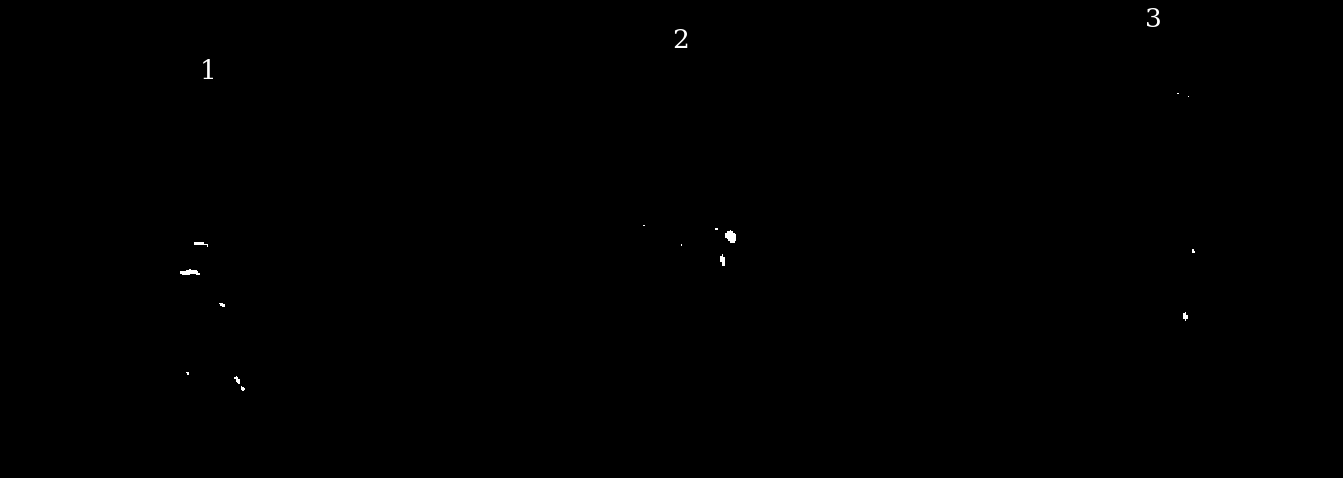

In [19]:
center_vol_plot(pred_vol[0])

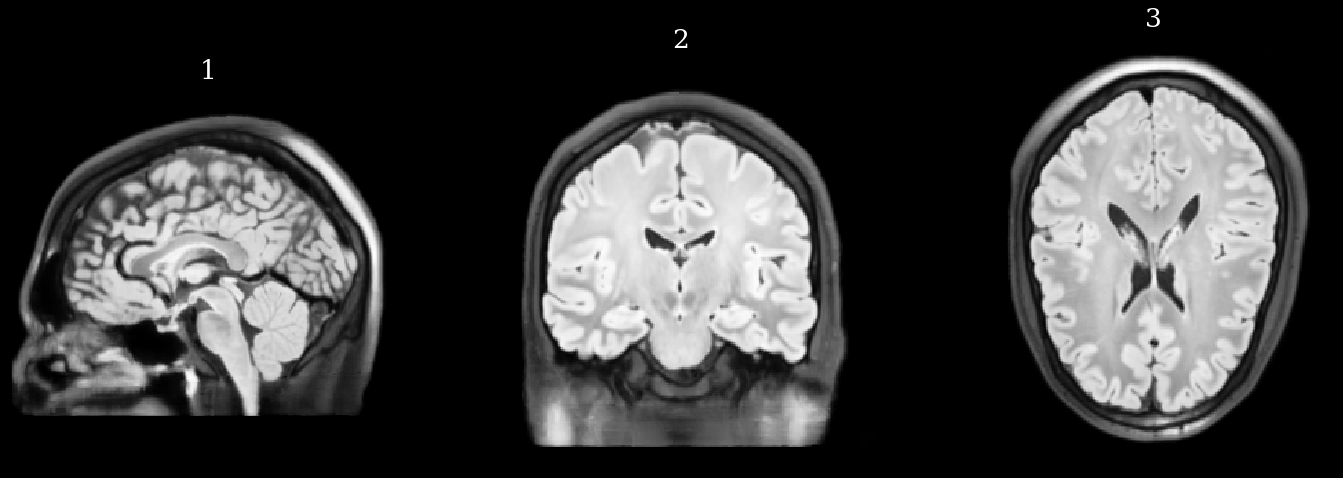

In [20]:
center_vol_plot(ds.val_img[0])

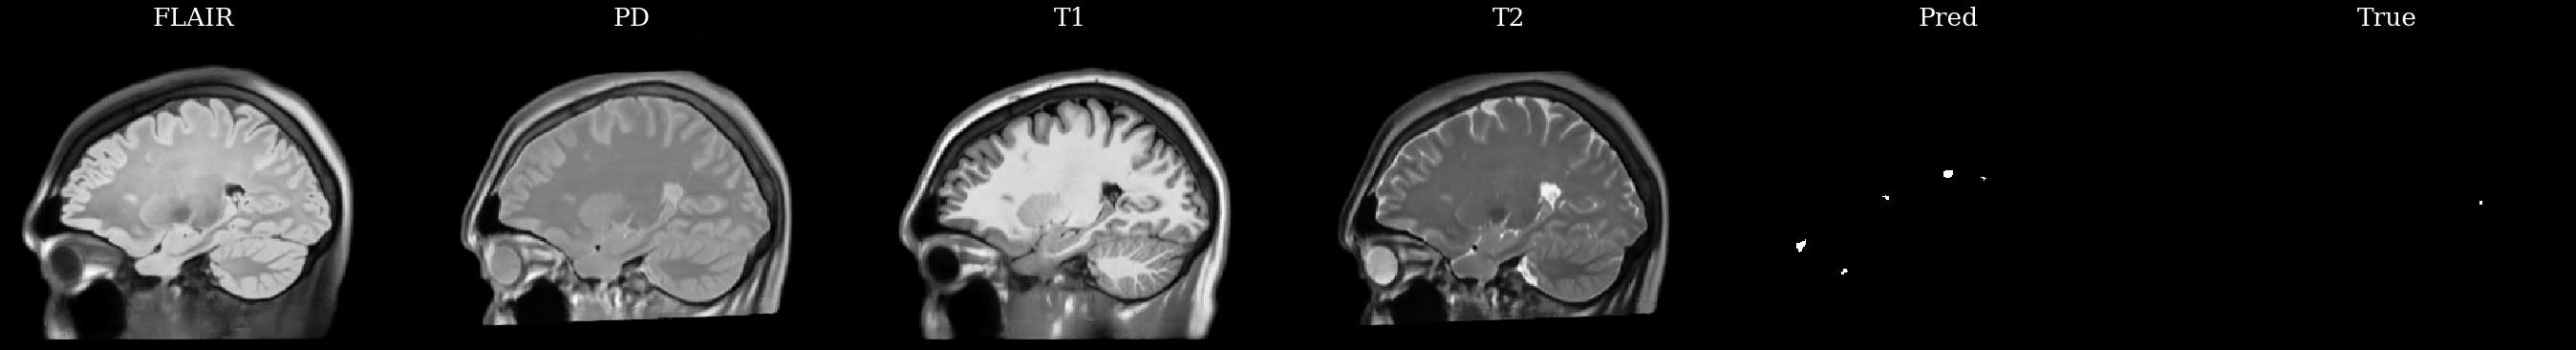

In [22]:
i = 150
multiplot(
    [
        ds.val_img[0][i],
        ds.val_img[1][i],
        ds.val_img[2][i],
        ds.val_img[3][i],
        pred_vol[0][i],
        ds.val_lbl[0][i],
    ],
    ['FLAIR', 'PD', 'T1', 'T2', 'Pred', 'True']
)